# Case Study 4.2 Topic Modelling by Clustering Emebeddings

In the second case study of Chapter 4 we explore using the embeddings to find semantic groups inside our set of essays.

The raw scripts used to populate this notebook can be found here:
* [Ellbow Method - CaseStudy_4.2_01-00.py](CaseStudy_4.2_01-00.py)
* [Create Clusters- CaseStudy_4.2_01-01.py](CaseStudy_4.2_01-00.py)

We start by running some experiments to determine the ideal number of clusters to use.

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import silhouette_score

In [ ]:
df = pd.read_csv("data/complete_with_features.csv")

In [ ]:
embeddings = "Embeddings_bert-base-uncased.npy"

In [ ]:
def expand_array_col(df, col_name):
    expanded = df[col_name].apply(pd.Series)
    expanded.columns = [f'{col_name}_{i+1}' for i in range(expanded.shape[1])]
    df_expanded = pd.concat([df.drop(col_name, axis=1), expanded], axis=1)
    return df_expanded, expanded.columns


In [ ]:
embs = np.load(embeddings, allow_pickle=True,)
df["embedding"] = list(embs)
newdf, cols = expand_array_col(df, "embedding")

In [ ]:
train = newdf[newdf["RANDOM"]<0.8]
test = newdf[newdf["RANDOM"]>=0.8]
X_train = train.loc[:,cols]
y_train = train.loc[:,"generated"]
X_test = test.loc[:,cols]
y_test = test.loc[:,"generated"]

In [ ]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
sil = []

In [ ]:
K = range(2, 28)

for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X_train)
    distortions.append(sum(np.min(cdist(X_train, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / X_train.shape[0])
    inertias.append(kmeanModel.inertia_)
    labels = kmeanModel.labels_
    sil.append(silhouette_score(X_train, labels, metric = 'euclidean'))
    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]

Distortion values:
2 : 9.83641197996458
3 : 9.125306679397326
4 : 8.626368245489724
5 : 8.277930898544978
6 : 7.955929340879311
7 : 7.692748441634489
8 : 7.577249383012391
9 : 7.394292564432435
10 : 7.2446979304107
11 : 7.106480488842003
12 : 6.996879738417278
13 : 6.83929266454772
14 : 6.750399149181982
15 : 6.662449139507448
16 : 6.600079033167845
17 : 6.5486313248748935
18 : 6.444975432121382
19 : 6.37048086490195
20 : 6.296080193320672
21 : 6.231074490470451
22 : 6.187167254090194
23 : 6.14651018846568
24 : 6.096066452442067
25 : 6.0639967459489625
26 : 6.028060907568761
27 : 6.00054458577102


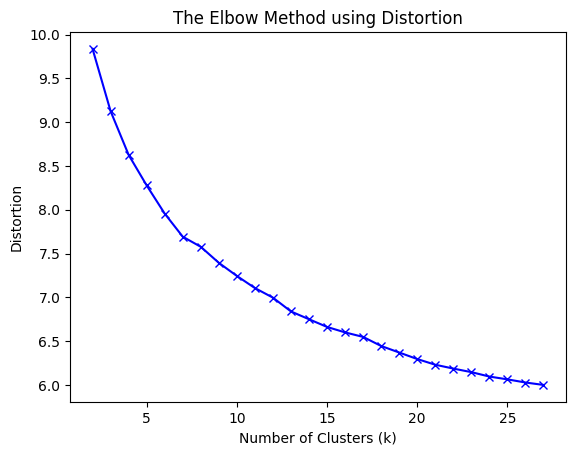

In [9]:
print("Distortion values:")
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()


Inertia values:
2 : 515565.53125
3 : 478294.0625
4 : 452142.46875
5 : 433879.25
6 : 417001.9375
7 : 403207.84375
8 : 397153.96875
9 : 387564.46875
10 : 379723.40625
11 : 372479.125
12 : 366734.40625
13 : 358474.71875
14 : 353815.4375
15 : 349205.625
16 : 345936.59375
17 : 343239.875
18 : 337806.96875
19 : 333902.5625
20 : 330002.75
21 : 326595.34375
22 : 324294.21875
23 : 322163.1875
24 : 319519.25
25 : 317838.3125
26 : 315954.8125
27 : 314512.59375


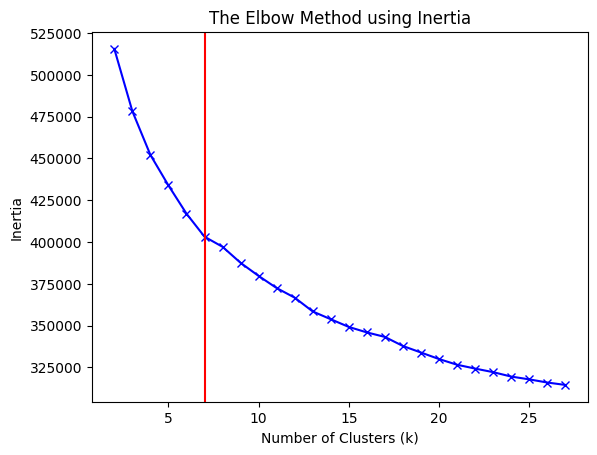

In [10]:
print("Inertia values:")
for key, val in mapping2.items():
    print(f'{key} : {val}')

plt.plot(K, inertias, 'bx-')
plt.axvline(x=7, color='red')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

Silouette values:


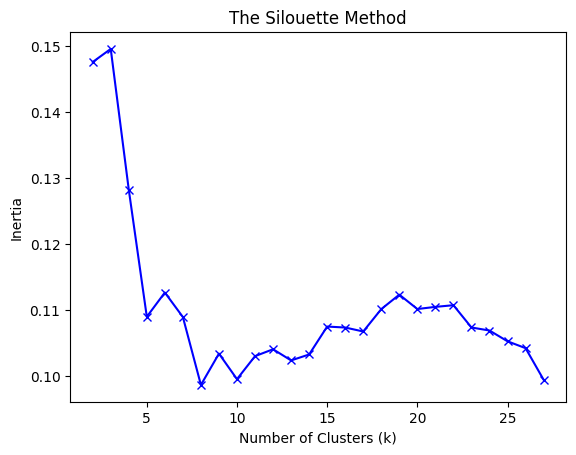

In [11]:
print("Silouette values:")
plt.plot(K, sil, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Silouette Method')
plt.show()

## Create Clusters

After the above analysis we settled on 7 as a reasonable number of clusters to use.
Note: that this example did not have a clear outcome using the elbow methods, 7 appeared to be a parameter setting that would capture large amounts of the observable variation.

In [ ]:
X = newdf.loc[:,cols]

In [ ]:
k = 7
kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X)

In [ ]:
labels = kmeanModel.labels_
distances_to_all_centroids = kmeanModel.transform(X)

distances_to_assigned_centroid = []
for i, label in enumerate(labels):
    distances_to_assigned_centroid.append(distances_to_all_centroids[i, label])

In [ ]:
df['cluster'] = labels
df['dist_to_centroid']=  distances_to_assigned_centroid

newdf = df.loc[:,['source','text', 'generated', 'cluster','dist_to_centroid', 'text_len', 'text_avg_wl']].copy()
newdf.to_csv("data/clustered_data.csv", index=False)